# Feature Engineering for Expedia Hotel Recommendations

This notebook performs feature engineering on the Expedia hotel dataset to create more informative features for the recommendation system. We'll leverage insights from the data understanding and imputation notebooks to create features that might improve our model's performance.

The main categories of features we'll create are:

1. **Time-based Features**: Extract more information from timestamps
2. **User-based Features**: User preferences and behaviors
3. **Property-based Features**: Enhanced hotel characteristics
4. **Price and Value Features**: Price-related calculations
5. **Competitive Position Features**: How a hotel compares to competitors
6. **Interaction Features**: Combined features capturing relationships

Let's start by importing the necessary libraries and loading the data.

In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plotting styles
sns.set_style("whitegrid")
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)

## Loading the Dataset

In [7]:
# Load the imputed dataset
print("Loading imputed dataset...")
try:
    df = pd.read_csv("../data/training_set_VU_DM_imputed.csv")
    print(f"Loaded {len(df):,} rows with {len(df.columns)} columns")
except FileNotFoundError:
    print("ERROR: Imputed training file not found. Loading original file instead...")
    df = pd.read_csv("../data/training_set_VU_DM.csv")
    print(f"Loaded {len(df):,} rows with {len(df.columns)} columns")

# Display first few rows to understand the data structure
df.head()

Loading imputed dataset...
Loaded 4,958,347 rows with 54 columns


,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.50,1,2.83,0.04,4.95,27,104.77,0,23246,1,0,4,0,1,1,NaN,1298.55,1,NaN,NaN,NaN,0.00,0.00,NaN,0.00,0.00,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.00,1,2.20,0.01,5.03,26,170.74,0,23246,1,0,4,0,1,1,NaN,1298.55,1,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,0.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,0,NaN,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.50,1,2.20,0.02,4.92,21,179.80,0,23246,1,0,4,0,1,1,NaN,1298.55,1,NaN,NaN,NaN,0.00,0.00,NaN,0.00,0.00,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,0,NaN,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.00,1,2.83,0.01,4.39,34,602.77,0,23246,1,0,4,0,1,1,NaN,1298.55,1,NaN,NaN,NaN,-1.00,0.00,5.00,-1.00,0.00,5.00,NaN,NaN,NaN,0.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.00,0.00,5.00,0,NaN,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.50,1,2.64,0.12,4.93,4,143.58,0,23246,1,0,4,0,1,1,NaN,1298.55,1,NaN,NaN,NaN,0.00,0.00,NaN,0.00,0.00,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,0,NaN,0


In [8]:
# Check for missing values to confirm the dataset is properly imputed
missing = df.isnull().sum()
if missing.sum() > 0:
    print("There are still missing values in the dataset:")
    print(missing[missing > 0])
else:
    print("Dataset is fully imputed with no missing values.")

There are still missing values in the dataset:
visitor_hist_starrating      4706481
visitor_hist_adr_usd         4705359
srch_query_affinity_score    4640941
comp1_rate                   4838417
comp1_inv                    4828788
comp1_rate_percent_diff      4863908
comp2_rate                   2933675
comp2_inv                    2828078
comp2_rate_percent_diff      4402109
comp3_rate                   3424059
comp3_inv                    3307357
comp3_rate_percent_diff      4485550
comp4_rate                   4650969
comp4_inv                    4614684
comp4_rate_percent_diff      4827261
comp5_rate                   2735974
comp5_inv                    2598327
comp5_rate_percent_diff      4117248
comp6_rate                   4718190
comp6_inv                    4697371
comp6_rate_percent_diff      4862173
comp7_rate                   4642999
comp7_inv                    4601925
comp7_rate_percent_diff      4819832
comp8_rate                   3041693
comp8_inv                   

## 1. Base Feature Extraction

Let's first make sure we have our target variable (relevance) defined based on clicks and bookings.

Relevance score distribution:
relevance
0    4736468
2     138390
1      83489
Name: count, dtype: int64


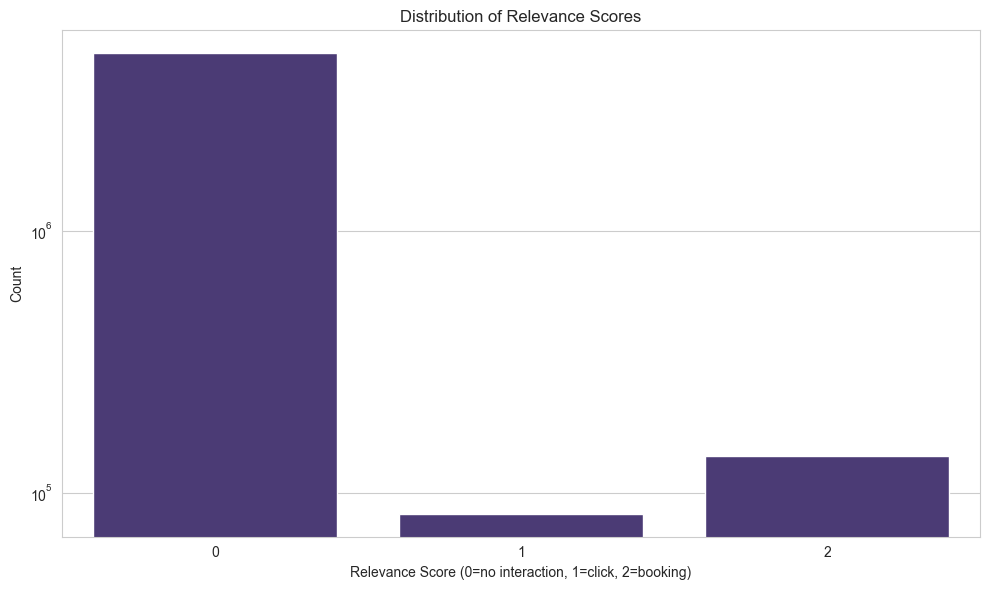

In [9]:
# Create relevance score
df['relevance'] = 0
df.loc[df['click_bool'] == 1, 'relevance'] = 1
df.loc[df['booking_bool'] == 1, 'relevance'] = 2

print("Relevance score distribution:")
relevance_counts = df['relevance'].value_counts()
print(relevance_counts)

# Visualize the distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='relevance', data=df)
plt.title('Distribution of Relevance Scores')
plt.xlabel('Relevance Score (0=no interaction, 1=click, 2=booking)')
plt.ylabel('Count')
plt.yscale('log')  # Log scale for better visualization
plt.tight_layout()
plt.show()

## 2. Time-based Features

Extract features from the date_time column to capture temporal patterns.

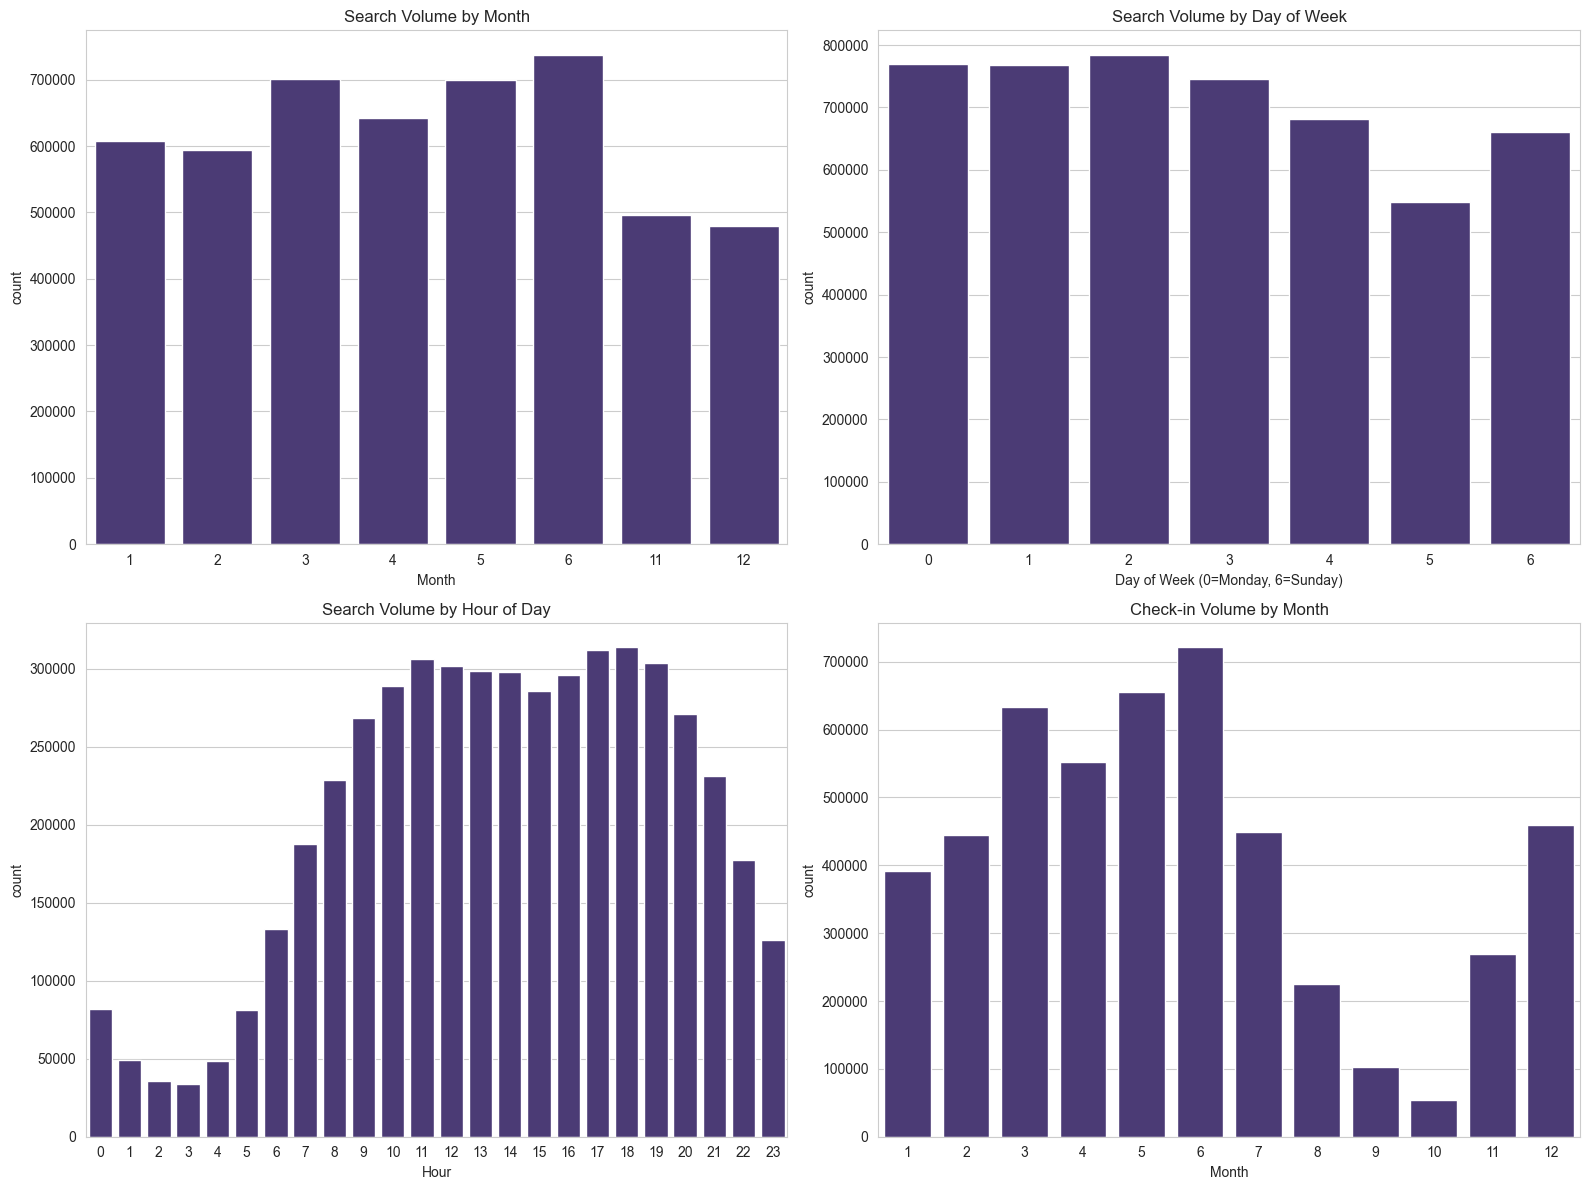

Time-based features added:
year, month, day, dayofweek, hour, season, is_weekend, day_part, days_since_first_date, checkin_month, checkin_dayofweek, checkin_season, is_holiday_season


In [10]:
# Convert date_time to datetime format
df['date_time'] = pd.to_datetime(df['date_time'])

# Extract basic time components
df['year'] = df['date_time'].dt.year
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day
df['dayofweek'] = df['date_time'].dt.dayofweek  # 0=Monday, 6=Sunday
df['hour'] = df['date_time'].dt.hour

# Create seasonal features
# Spring (March-May), Summer (June-August), Fall (September-November), Winter (December-February)
df['season'] = df['month'].apply(lambda x: 0 if x in [12, 1, 2] else 
                                       1 if x in [3, 4, 5] else 
                                       2 if x in [6, 7, 8] else 3)

# Weekend indicator
df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# Part of day
df['day_part'] = df['hour'].apply(lambda x: 0 if 0 <= x < 6 else 
                                        1 if 6 <= x < 12 else 
                                        2 if 12 <= x < 18 else 3)  # 0=night, 1=morning, 2=afternoon, 3=evening

# Time since first date in dataset (normalized)
min_date = df['date_time'].min()
df['days_since_first_date'] = (df['date_time'] - min_date).dt.total_seconds() / (24 * 60 * 60)

# Check-in date based on search date and booking window
df['checkin_date'] = df['date_time'] + pd.to_timedelta(df['srch_booking_window'], unit='D')
df['checkin_month'] = df['checkin_date'].dt.month
df['checkin_dayofweek'] = df['checkin_date'].dt.dayofweek
df['checkin_season'] = df['checkin_month'].apply(lambda x: 0 if x in [12, 1, 2] else 
                                                 1 if x in [3, 4, 5] else 
                                                 2 if x in [6, 7, 8] else 3)

# Holiday season indicator (December holiday season)
df['is_holiday_season'] = ((df['checkin_month'] == 12) & (df['checkin_date'].dt.day >= 15)) | ((df['checkin_month'] == 1) & (df['checkin_date'].dt.day <= 10))
df['is_holiday_season'] = df['is_holiday_season'].astype(int)

# Visualize some of the time-based features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.countplot(x='month', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Search Volume by Month')
axes[0, 0].set_xlabel('Month')

sns.countplot(x='dayofweek', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Search Volume by Day of Week')
axes[0, 1].set_xlabel('Day of Week (0=Monday, 6=Sunday)')

sns.countplot(x='hour', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Search Volume by Hour of Day')
axes[1, 0].set_xlabel('Hour')

sns.countplot(x='checkin_month', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Check-in Volume by Month')
axes[1, 1].set_xlabel('Month')

plt.tight_layout()
plt.show()

print("Time-based features added:")
time_features = ['year', 'month', 'day', 'dayofweek', 'hour', 'season', 'is_weekend', 'day_part', 
                'days_since_first_date', 'checkin_month', 'checkin_dayofweek', 'checkin_season', 
                'is_holiday_season']
print(", ".join(time_features))

## 3. User-based Features

Create features about user preferences and behavior patterns.

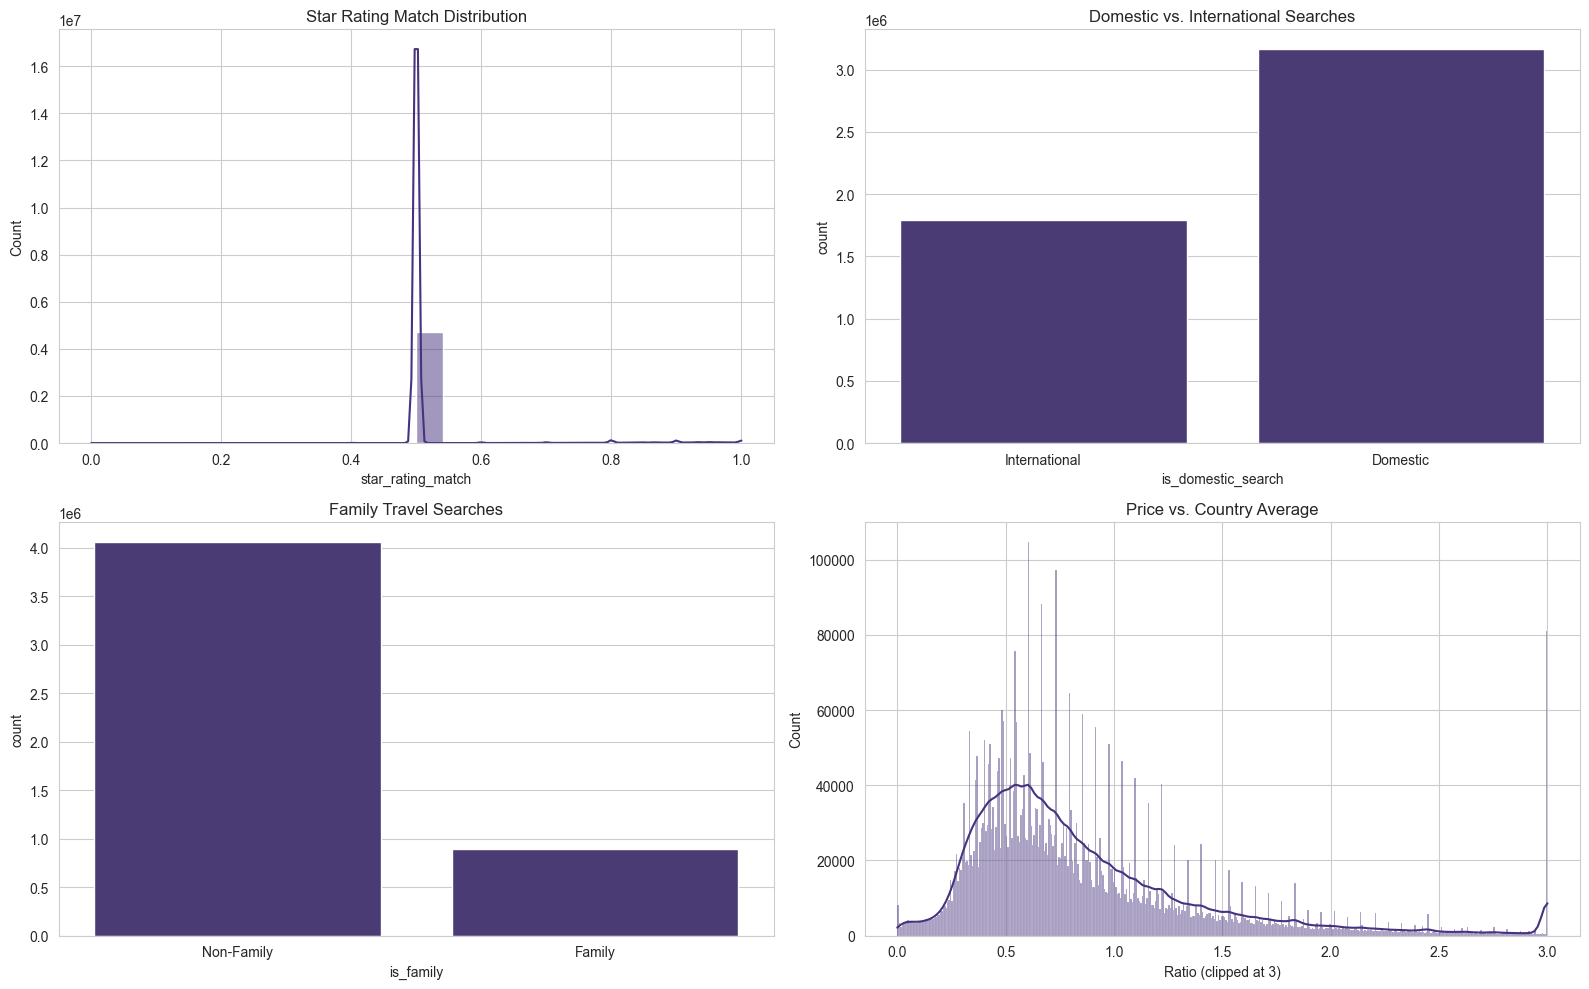

User-based features added:
has_user_history, star_rating_match, price_match, is_domestic_search, total_travelers, has_children, is_family, rooms_per_person, is_short_stay, is_long_stay, is_last_minute, is_early_booking, country_avg_starrating, country_avg_adr_usd, country_avg_price_usd, country_avg_stay, country_avg_booking_window, country_avg_adults, country_avg_children, price_vs_country_avg, stay_vs_country_avg


In [11]:
# Default values for missing user history
df['visitor_hist_starrating'] = df['visitor_hist_starrating'].fillna(0)
df['visitor_hist_adr_usd'] = df['visitor_hist_adr_usd'].fillna(0)

# User history preference indicators
df['has_user_history'] = ((df['visitor_hist_starrating'] > 0) | (df['visitor_hist_adr_usd'] > 0)).astype(int)

# Star rating preference match
# How close is this hotel's star rating to the user's historical preference?
df['star_rating_match'] = 1 - (abs(df['prop_starrating'] - df['visitor_hist_starrating']) / 5)
df.loc[df['visitor_hist_starrating'] == 0, 'star_rating_match'] = 0.5  # Default for users with no history

# Price preference match
# Is this hotel's price similar to what the user historically paid?
df['price_match'] = 1 - np.minimum(abs(df['price_usd'] - df['visitor_hist_adr_usd']) / 
                                  np.maximum(df['visitor_hist_adr_usd'], 100), 1)
df.loc[df['visitor_hist_adr_usd'] == 0, 'price_match'] = 0.5  # Default for users with no history

# Is user searching in their country?
df['is_domestic_search'] = (df['visitor_location_country_id'] == df['prop_country_id']).astype(int)

# Group size features
df['total_travelers'] = df['srch_adults_count'] + df['srch_children_count']
df['has_children'] = (df['srch_children_count'] > 0).astype(int)
df['is_family'] = ((df['srch_adults_count'] >= 2) & (df['srch_children_count'] > 0)).astype(int)
df['rooms_per_person'] = df['srch_room_count'] / df['total_travelers']

# Trip characteristics
df['is_short_stay'] = (df['srch_length_of_stay'] <= 3).astype(int)
df['is_long_stay'] = (df['srch_length_of_stay'] >= 7).astype(int)
df['is_last_minute'] = (df['srch_booking_window'] <= 3).astype(int)
df['is_early_booking'] = (df['srch_booking_window'] >= 30).astype(int)

# Average group stats by visitor country
country_avg_df = df.groupby('visitor_location_country_id').agg({
    'visitor_hist_starrating': 'mean',
    'visitor_hist_adr_usd': 'mean',
    'price_usd': 'mean',
    'srch_length_of_stay': 'mean',
    'srch_booking_window': 'mean',
    'srch_adults_count': 'mean',
    'srch_children_count': 'mean',
}).reset_index()

country_avg_df.columns = ['visitor_location_country_id', 'country_avg_starrating', 'country_avg_adr_usd',
                          'country_avg_price_usd', 'country_avg_stay', 'country_avg_booking_window',
                          'country_avg_adults', 'country_avg_children']

# Merge country averages back to the main dataframe
df = pd.merge(df, country_avg_df, on='visitor_location_country_id', how='left')

# Calculate differences from country averages
df['price_vs_country_avg'] = df['price_usd'] / df['country_avg_price_usd']
df['stay_vs_country_avg'] = df['srch_length_of_stay'] / df['country_avg_stay']

# Visualize some user-based features
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

sns.histplot(df['star_rating_match'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Star Rating Match Distribution')

sns.countplot(x='is_domestic_search', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Domestic vs. International Searches')
axes[0, 1].set_xticklabels(['International', 'Domestic'])

sns.countplot(x='is_family', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Family Travel Searches')
axes[1, 0].set_xticklabels(['Non-Family', 'Family'])

sns.histplot(df['price_vs_country_avg'].clip(0, 3), kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Price vs. Country Average')
axes[1, 1].set_xlabel('Ratio (clipped at 3)')

plt.tight_layout()
plt.show()

print("User-based features added:")
user_features = ['has_user_history', 'star_rating_match', 'price_match', 'is_domestic_search',
                'total_travelers', 'has_children', 'is_family', 'rooms_per_person',
                'is_short_stay', 'is_long_stay', 'is_last_minute', 'is_early_booking',
                'country_avg_starrating', 'country_avg_adr_usd', 'country_avg_price_usd',
                'country_avg_stay', 'country_avg_booking_window', 'country_avg_adults',
                'country_avg_children', 'price_vs_country_avg', 'stay_vs_country_avg']
print(", ".join(user_features))

## 4. Property-based Features

Create enhanced features about hotel properties.

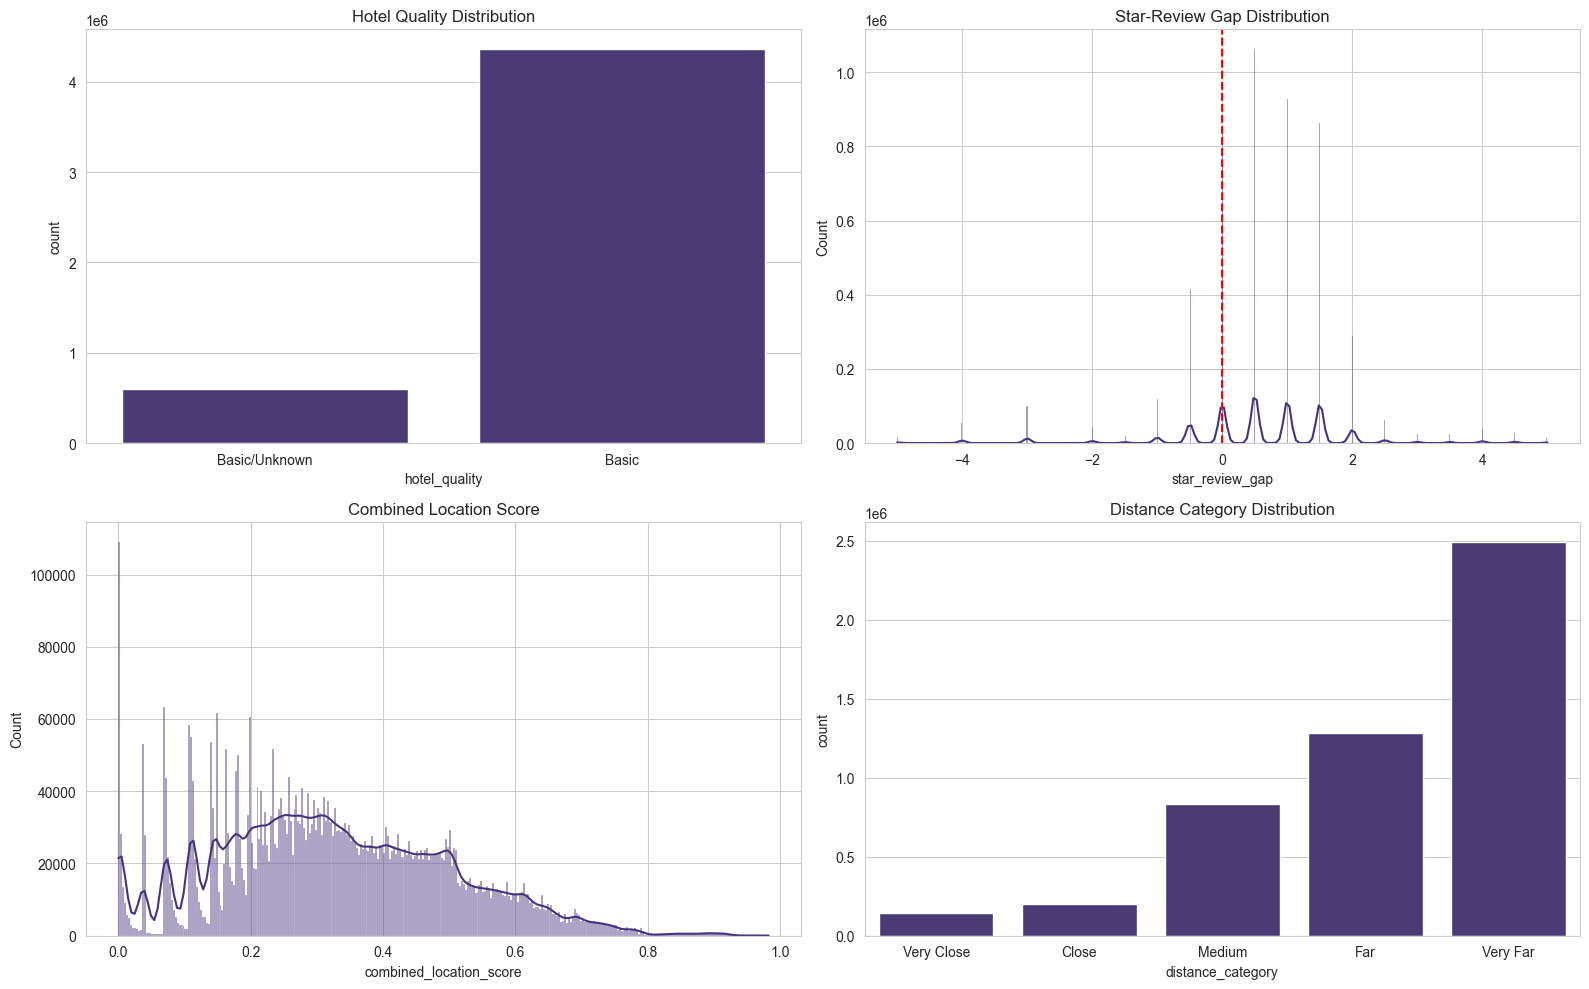

Property-based features added:
hotel_quality, star_review_gap, norm_location_score1, norm_location_score2, combined_location_score, location_quality, distance_category, prop_frequency, prop_popularity, prop_country_rank, prop_country_rank_pct, prop_matches_destination


In [12]:
# Fill any missing property features with appropriate defaults
for col in ['prop_starrating', 'prop_review_score', 'prop_location_score1', 'prop_location_score2']:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())

# Hotel quality tiers
df['hotel_quality'] = 0  # Default: Unknown/Low quality
df.loc[(df['prop_starrating'] >= 4) & (df['prop_review_score'] >= 4), 'hotel_quality'] = 3  # High quality
df.loc[(df['prop_starrating'] >= 3) & (df['prop_review_score'] >= 3.5), 'hotel_quality'] = 2  # Medium quality
df.loc[(df['prop_starrating'] >= 2) & (df['prop_review_score'] >= 3), 'hotel_quality'] = 1  # Basic quality

# Star-review gap (difference between star rating and reviews)
# Positive values mean the hotel is better than its star rating suggests
df['star_review_gap'] = (df['prop_review_score'] / 5 * 5) - df['prop_starrating']

# Location quality combined score
# Combine both location scores into a single metric
# First normalize both scores to 0-1 range
max_loc1 = df['prop_location_score1'].max()
max_loc2 = df['prop_location_score2'].max()
df['norm_location_score1'] = df['prop_location_score1'] / max_loc1
df['norm_location_score2'] = df['prop_location_score2'] / max_loc2

# Weighted combination (giving more weight to score1 as it appears more important)
df['combined_location_score'] = (0.7 * df['norm_location_score1']) + (0.3 * df['norm_location_score2'])

# Location quality tier
df['location_quality'] = pd.qcut(df['combined_location_score'], q=4, labels=[0, 1, 2, 3]).astype(int)

# Distance buckets (only if orig_destination_distance exists)
if 'orig_destination_distance' in df.columns:
    df['orig_destination_distance'] = df['orig_destination_distance'].fillna(df['orig_destination_distance'].median())
    # Create distance categories
    df['distance_category'] = pd.cut(df['orig_destination_distance'], 
                                    bins=[0, 10, 50, 200, 1000, np.inf], 
                                    labels=[0, 1, 2, 3, 4])
    df['distance_category'] = df['distance_category'].astype(int)
else:
    df['distance_category'] = -1  # Default if distance not available

# Property popularity
# Count how many times each property appears in the dataset
prop_counts = df['prop_id'].value_counts().reset_index()
prop_counts.columns = ['prop_id', 'prop_frequency']
df = pd.merge(df, prop_counts, on='prop_id', how='left')

# Normalize to 0-1 range
df['prop_popularity'] = df['prop_frequency'] / df['prop_frequency'].max()

# Country-specific hotel ranking
# Rank hotels within each country by star rating and reviews
df['prop_country_rank'] = df.groupby('prop_country_id')['prop_starrating'].rank(ascending=False, method='dense')
df['prop_country_rank_pct'] = df.groupby('prop_country_id')['prop_starrating'].rank(pct=True)

# Property matches search destination
df['prop_matches_destination'] = (df['srch_destination_id'] == df['prop_country_id']).astype(int)

# Visualize some property-based features
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

sns.countplot(x='hotel_quality', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Hotel Quality Distribution')
axes[0, 0].set_xticklabels(['Basic/Unknown', 'Basic', 'Medium', 'High'])

sns.histplot(df['star_review_gap'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Star-Review Gap Distribution')
axes[0, 1].axvline(x=0, color='r', linestyle='--')

sns.histplot(df['combined_location_score'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Combined Location Score')

sns.countplot(x='distance_category', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Distance Category Distribution')
axes[1, 1].set_xticklabels(['Very Close', 'Close', 'Medium', 'Far', 'Very Far'])

plt.tight_layout()
plt.show()

print("Property-based features added:")
property_features = ['hotel_quality', 'star_review_gap', 'norm_location_score1', 'norm_location_score2',
                    'combined_location_score', 'location_quality', 'distance_category',
                    'prop_frequency', 'prop_popularity', 'prop_country_rank', 'prop_country_rank_pct',
                    'prop_matches_destination']
print(", ".join(property_features))

## 5. Price and Value Features

Create features that capture price and value aspects of hotels.

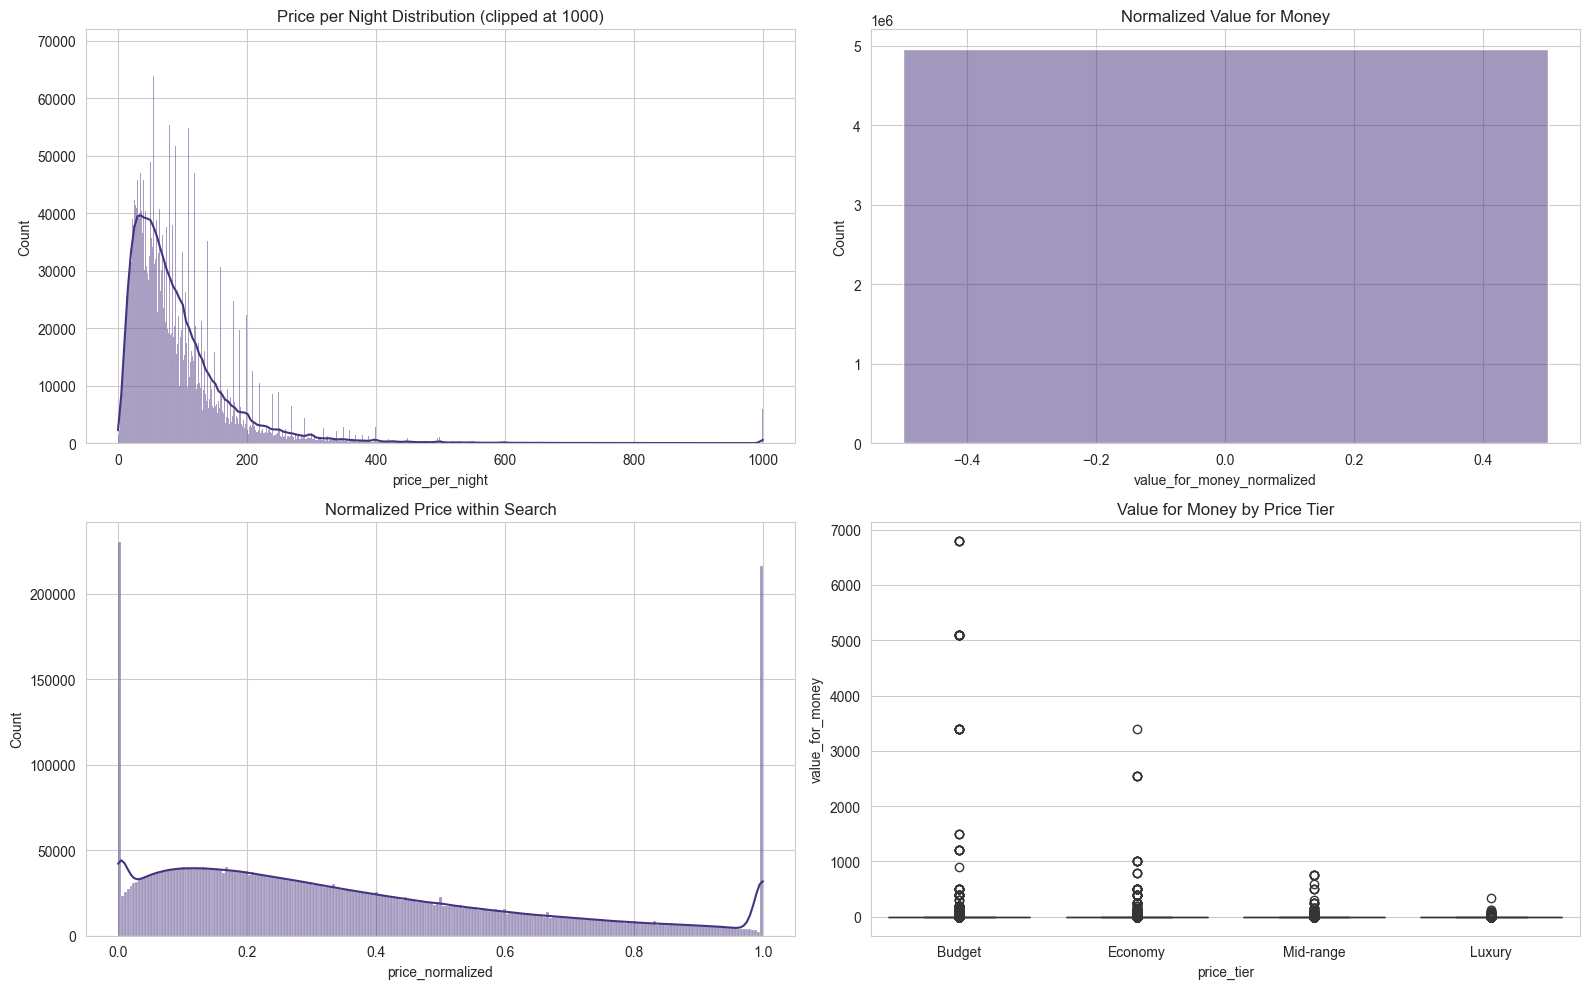

Price and value features added:
price_per_person, price_per_night, price_per_room, value_for_money, value_for_money_normalized, price_normalized, price_rank, price_rank_pct, price_tier, price_zscore, has_promotion, log_price_ratio, price_discount


In [14]:
# Price per person
df['price_per_person'] = df['price_usd'] / df['total_travelers']

# Price per night
df['price_per_night'] = df['price_usd'] / df['srch_length_of_stay']
df.loc[df['srch_length_of_stay'] == 0, 'price_per_night'] = df['price_usd']

# Price per room
df['price_per_room'] = df['price_usd'] / df['srch_room_count']

# Value for money metrics
df['value_for_money'] = df['prop_starrating'] / df['price_per_night']
df['value_for_money_normalized'] = df['value_for_money'] / df['value_for_money'].max()

# Price normalization within search
df['price_normalized'] = df.groupby('srch_id')['price_usd'].transform(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-10))

# Price rank within search (1 = cheapest)
df['price_rank'] = df.groupby('srch_id')['price_usd'].rank(method='dense')
df['price_rank_pct'] = df.groupby('srch_id')['price_usd'].rank(pct=True)

# Price tiers within search - using a robust approach that handles edge cases
def create_price_tiers(prices):
    """
    Create price tiers (0-3) for a series of prices.
    Handles cases with few unique values or duplicate values that cause pd.qcut to fail.
    """
    if len(prices) <= 1:
        return pd.Series([1] * len(prices))  # Default to mid-low tier for single price
    
    n_unique = len(prices.unique())
    
    if n_unique == 1:
        return pd.Series([1] * len(prices))  # Default to mid-low tier
    
    try:
        # Try standard quartiles first
        return pd.qcut(prices, q=4, labels=False)
    except ValueError:
        try:
            # If that fails, try with fewer bins based on unique values
            return pd.qcut(prices, q=min(n_unique, 3), labels=False)
        except ValueError:
            # If qcut still fails, fall back to simple binning
            return pd.cut(prices, bins=min(n_unique, 4), labels=False)

# Apply the robust function to each search_id group
df['price_tier'] = df.groupby('srch_id')['price_usd'].transform(create_price_tiers)
df['price_tier'] = df['price_tier'].fillna(1).astype(int)  # Default to mid-low if any NaN values

# Price standard deviations from mean (within search)
df['price_zscore'] = df.groupby('srch_id')['price_usd'].transform(lambda x: (x - x.mean()) / (x.std() + 1e-10))

# Price discount features
df['has_promotion'] = df['promotion_flag']
df['log_price_ratio'] = np.log1p(df['price_usd']) / df['prop_log_historical_price']
df['price_discount'] = 1 - (df['price_usd'] / np.exp(df['prop_log_historical_price']))

# Visualize some price and value features
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

sns.histplot(df['price_per_night'].clip(0, 1000), kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Price per Night Distribution (clipped at 1000)')

sns.histplot(df['value_for_money_normalized'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Normalized Value for Money')

sns.histplot(df['price_normalized'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Normalized Price within Search')

sns.boxplot(x='price_tier', y='value_for_money', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Value for Money by Price Tier')
axes[1, 1].set_xticklabels(['Budget', 'Economy', 'Mid-range', 'Luxury'])

plt.tight_layout()
plt.show()

print("Price and value features added:")
price_features = ['price_per_person', 'price_per_night', 'price_per_room', 
                 'value_for_money', 'value_for_money_normalized', 'price_normalized',
                 'price_rank', 'price_rank_pct', 'price_tier', 'price_zscore',
                 'has_promotion', 'log_price_ratio', 'price_discount']
print(", ".join(price_features))

## 6. Competitive Position Features

Create features that capture how a hotel compares to competitors.

Found 8 competitor price columns
Found 8 competitor inventory columns
Found 8 competitor price difference columns


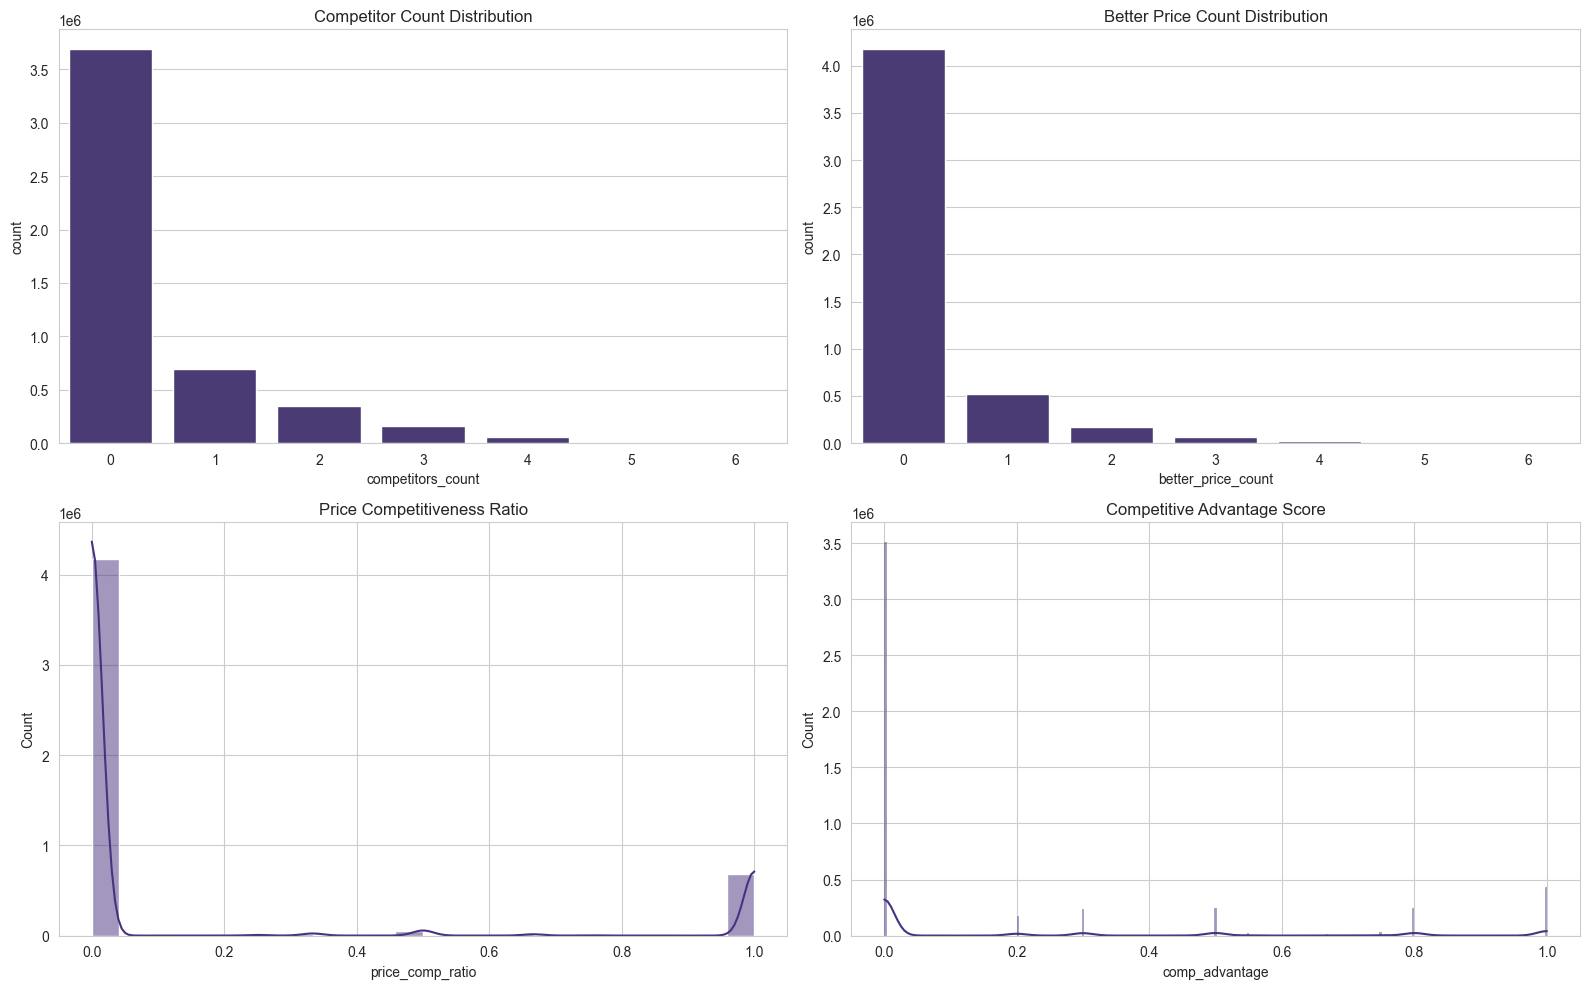

Competitive position features added:
comp_rate_available, comp_inv_available, competitors_count, better_price_count, worse_price_count, price_comp_ratio, avg_price_diff, comp_advantage


In [15]:
# Check which competitor columns we have
comp_price_cols = [col for col in df.columns if col.startswith('comp') and col.endswith('rate')]
comp_inv_cols = [col for col in df.columns if col.startswith('comp') and col.endswith('inv')]
comp_diff_cols = [col for col in df.columns if col.startswith('comp') and col.endswith('diff')]

print(f"Found {len(comp_price_cols)} competitor price columns")
print(f"Found {len(comp_inv_cols)} competitor inventory columns")
print(f"Found {len(comp_diff_cols)} competitor price difference columns")

# Competitor availability count
df['comp_rate_available'] = df[comp_price_cols].notnull().sum(axis=1)
df['comp_inv_available'] = df[comp_inv_cols].notnull().sum(axis=1)

# Total competition count
df['competitors_count'] = 0
for i in range(1, 9):  # Assuming 8 competitors
    price_col = f'comp{i}_rate'
    if price_col in df.columns:
        df['competitors_count'] += ((df[price_col] == 1) | (df[price_col] == -1)).astype(int)

# Better price than competitors count
df['better_price_count'] = 0
for i in range(1, 9):
    price_col = f'comp{i}_rate'
    if price_col in df.columns:
        df['better_price_count'] += (df[price_col] == 1).astype(int)

# Worse price than competitors count
df['worse_price_count'] = 0
for i in range(1, 9):
    price_col = f'comp{i}_rate'
    if price_col in df.columns:
        df['worse_price_count'] += (df[price_col] == -1).astype(int)

# Competitive position ratio
df['price_comp_ratio'] = df['better_price_count'] / (df['competitors_count'] + 1e-10)

# Average price difference from competitors
df['avg_price_diff'] = df[comp_diff_cols].mean(axis=1)
df['avg_price_diff'] = df['avg_price_diff'].fillna(0)

# Competitive advantage score (higher means more competitive)
df['comp_advantage'] = df['price_comp_ratio'] * 0.5 + \
                     (df['competitors_count'] > 0).astype(int) * 0.3 + \
                     (df['avg_price_diff'] > 10).astype(int) * 0.2

# Visualize some competitive position features
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

sns.countplot(x='competitors_count', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Competitor Count Distribution')

sns.countplot(x='better_price_count', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Better Price Count Distribution')

sns.histplot(df['price_comp_ratio'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Price Competitiveness Ratio')

sns.histplot(df['comp_advantage'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Competitive Advantage Score')

plt.tight_layout()
plt.show()

print("Competitive position features added:")
comp_features = ['comp_rate_available', 'comp_inv_available', 'competitors_count',
                'better_price_count', 'worse_price_count', 'price_comp_ratio',
                'avg_price_diff', 'comp_advantage']
print(", ".join(comp_features))

## 7. Interaction Features

Create features that capture interactions between different attributes.

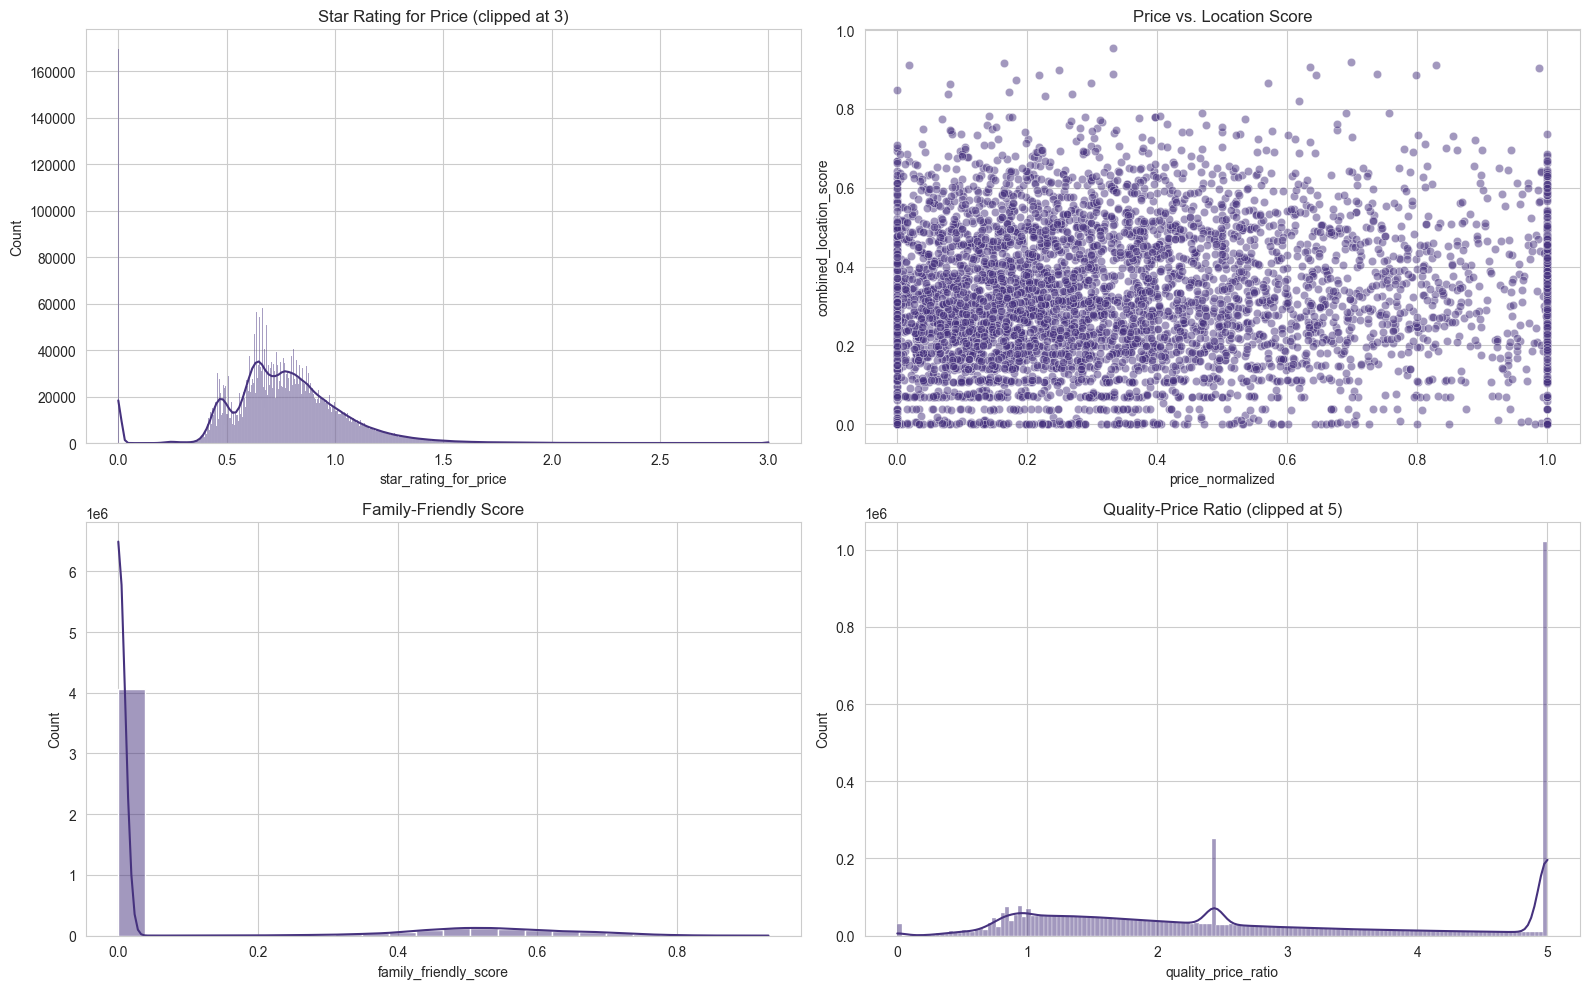

Interaction features added:
user_prop_country_match, star_rating_for_price, review_for_price, location_for_price, family_friendly_score, business_travel_score, vacation_score, quality_price_ratio


In [16]:
# User-property country match
df['user_prop_country_match'] = (df['visitor_location_country_id'] == df['prop_country_id']).astype(int)

# Star rating for price (higher = better deal)
df['star_rating_for_price'] = df['prop_starrating'] / np.log1p(df['price_per_night'])

# Review score for price
df['review_for_price'] = df['prop_review_score'] / np.log1p(df['price_per_night'])

# Location for price
df['location_for_price'] = df['combined_location_score'] / np.log1p(df['price_per_night'])

# Family-friendly score
# Higher for hotels that might be good for families
df['family_friendly_score'] = 0
df.loc[df['is_family'] == 1, 'family_friendly_score'] = (
    0.4 * df['combined_location_score'] +
    0.3 * (df['prop_starrating'] / 5) +
    0.2 * (df['prop_review_score'] / 5) +
    0.1 * (1 - df['price_normalized'])
)

# Business travel score
# Higher for hotels that might be good for business travelers
df['business_travel_score'] = df.apply(
    lambda x: 0.3 * (x['prop_starrating'] / 5) +
             0.3 * x['combined_location_score'] +
             0.2 * (x['prop_review_score'] / 5) +
             0.1 * (x['prop_brand_bool']) +
             0.1 * (1 if x['srch_adults_count'] == 1 and x['srch_room_count'] == 1 else 0),
    axis=1
)

# Vacation score 
# Higher for hotels that might be good for vacation
df['vacation_score'] = df.apply(
    lambda x: 0.25 * (x['prop_starrating'] / 5) +
             0.25 * x['combined_location_score'] +
             0.2 * (x['prop_review_score'] / 5) +
             0.2 * (1 if x['srch_length_of_stay'] >= 4 else 0) +
             0.1 * (1 if x['srch_saturday_night_bool'] == 1 else 0),
    axis=1
)

# Price vs. quality (higher = better quality than price suggests)
df['quality_price_ratio'] = (0.5 * (df['prop_starrating'] / 5) + 0.5 * (df['prop_review_score'] / 5)) / df['price_normalized']
df['quality_price_ratio'] = df['quality_price_ratio'].fillna(df['quality_price_ratio'].median())
df['quality_price_ratio'] = df['quality_price_ratio'].replace([np.inf, -np.inf], df['quality_price_ratio'].median())

# Visualize some interaction features
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

sns.histplot(df['star_rating_for_price'].clip(0, 3), kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Star Rating for Price (clipped at 3)')

sns.scatterplot(x='price_normalized', y='combined_location_score', 
               data=df.sample(5000), alpha=0.5, ax=axes[0, 1])
axes[0, 1].set_title('Price vs. Location Score')

sns.histplot(df['family_friendly_score'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Family-Friendly Score')

sns.histplot(df['quality_price_ratio'].clip(0, 5), kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Quality-Price Ratio (clipped at 5)')

plt.tight_layout()
plt.show()

print("Interaction features added:")
interaction_features = ['user_prop_country_match', 'star_rating_for_price', 'review_for_price',
                       'location_for_price', 'family_friendly_score', 'business_travel_score',
                       'vacation_score', 'quality_price_ratio']
print(", ".join(interaction_features))

## 8. Principal Component Analysis for Dimension Reduction

If we have too many features, we can use PCA to reduce dimensionality while preserving important information.

Total numeric features: 75

Variance explained by each PCA component:


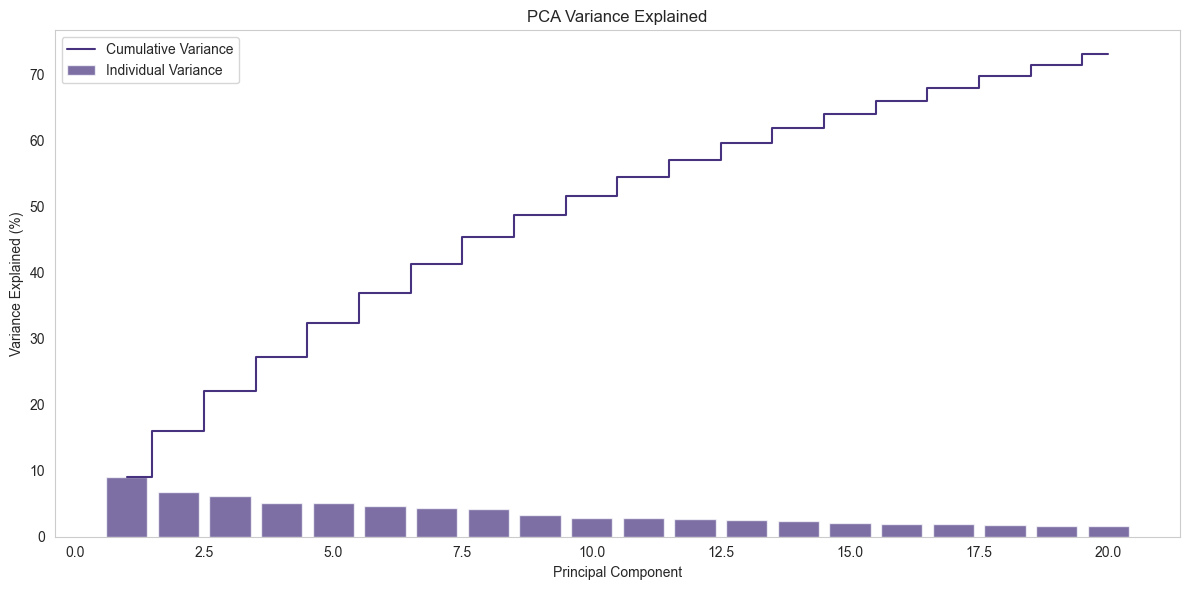


Top 10 features based on first principal component:
                    feature  importance
73           vacation_score        0.30
43        prop_country_rank        0.29
72    business_travel_score        0.29
44    prop_country_rank_pct        0.28
38  combined_location_score        0.25
36     norm_location_score1        0.25
39         location_quality        0.24
52               price_rank        0.23
53           price_rank_pct        0.22
54               price_tier        0.22


In [17]:
# Collect all numeric features
all_numeric_features = time_features + user_features + property_features + price_features + comp_features + interaction_features

# Select only numeric columns that exist in the dataframe
numeric_features = [col for col in all_numeric_features if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]

print(f"Total numeric features: {len(numeric_features)}")

# Create a subset with just numeric features
numeric_df = df[numeric_features].copy()

# Replace infinities and fill NaNs
for col in numeric_df.columns:
    numeric_df[col] = numeric_df[col].replace([np.inf, -np.inf], np.nan)
    if numeric_df[col].isnull().any():
        numeric_df[col] = numeric_df[col].fillna(numeric_df[col].median())

# Scale the data before PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

# Apply PCA to create 20 principal components
n_components = min(20, len(numeric_features))
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(scaled_data)

# Add PCA components to the dataframe
for i in range(n_components):
    df[f'pca_component_{i+1}'] = pca_result[:, i]

# Show variance explained by each component
print("\nVariance explained by each PCA component:")
explained_variance = pca.explained_variance_ratio_ * 100
cumulative_variance = np.cumsum(explained_variance)

# Plot the explained variance
plt.figure(figsize=(12, 6))
plt.bar(range(1, n_components+1), explained_variance, alpha=0.7, label='Individual Variance')
plt.step(range(1, n_components+1), cumulative_variance, where='mid', label='Cumulative Variance')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.title('PCA Variance Explained')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

print(f"\nTop 10 features based on first principal component:")
feature_importance = pd.DataFrame({
    'feature': numeric_features,
    'importance': np.abs(pca.components_[0])
}).sort_values('importance', ascending=False)
print(feature_importance.head(10))

## 9. Feature Correlations with Target

Let's analyze how our features correlate with the target variable (relevance).

Top 15 features positively correlated with relevance:
                    feature  correlation
37     norm_location_score2         0.07
77          pca_component_3         0.05
56            has_promotion         0.04
72    business_travel_score         0.03
44    prop_country_rank_pct         0.03
34            hotel_quality         0.03
73           vacation_score         0.02
39         location_quality         0.02
62       better_price_count         0.02
38  combined_location_score         0.02
64         price_comp_ratio         0.02
15              price_match         0.02
85         pca_component_11         0.01
66           comp_advantage         0.01
94         pca_component_20         0.01

Top 15 features negatively correlated with relevance:
                       feature  correlation
52                  price_rank        -0.07
90            pca_component_16        -0.05
55                price_zscore        -0.05
54                  price_tier        -0.04
57             

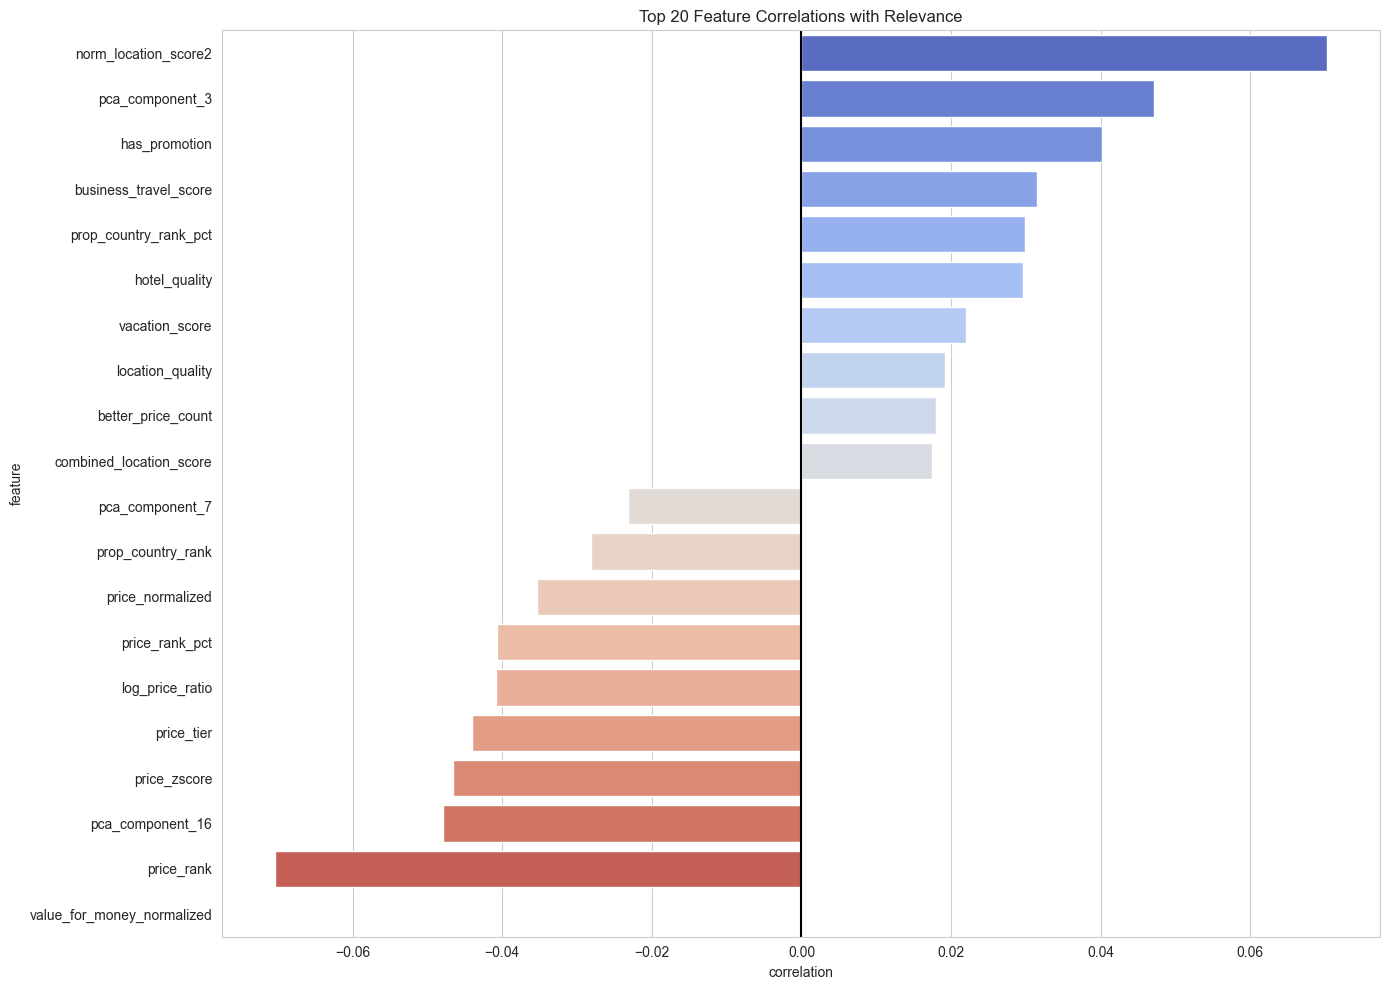

In [18]:
# Create a correlation dataframe for all numeric features vs. the relevance target
all_features = time_features + user_features + property_features + price_features + comp_features + interaction_features
existing_features = [col for col in all_features if col in df.columns]
pca_features = [f'pca_component_{i+1}' for i in range(n_components)]
all_existing_features = existing_features + pca_features

# Calculate correlations
correlation_series = df[all_existing_features + ['relevance']].corr()['relevance'].drop('relevance')
correlation_df = pd.DataFrame({
    'feature': correlation_series.index,
    'correlation': correlation_series.values
}).sort_values('correlation', ascending=False)

# Display top positive and negative correlations
print("Top 15 features positively correlated with relevance:")
print(correlation_df.head(15))

print("\nTop 15 features negatively correlated with relevance:")
print(correlation_df.tail(15).sort_values('correlation'))

# Plot the top correlations
plt.figure(figsize=(14, 10))
top_features = pd.concat([correlation_df.head(10), correlation_df.tail(10)])
sns.barplot(x='correlation', y='feature', data=top_features, palette='coolwarm')
plt.title('Top 20 Feature Correlations with Relevance')
plt.axvline(x=0, color='black', linestyle='-')
plt.tight_layout()
plt.show()

## 10. Save the Enhanced Dataset

Let's save our feature-engineered dataset for use in our models.

In [19]:
# List all columns to save
original_columns = [col for col in df.columns if col not in all_existing_features and col != 'checkin_date']
feature_columns = all_existing_features

# Columns to save (excluding date objects that can't be easily saved to CSV)
columns_to_save = original_columns + feature_columns

# Check dataframe for issues
for col in columns_to_save:
    if df[col].isnull().any():
        print(f"Column {col} has {df[col].isnull().sum()} missing values. Filling with appropriate defaults.")
        if pd.api.types.is_numeric_dtype(df[col]):
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 0)
            
    # Replace infinities if any
    if pd.api.types.is_numeric_dtype(df[col]):
        if (df[col] == np.inf).any() or (df[col] == -np.inf).any():
            print(f"Column {col} has infinite values. Replacing with median.")
            df[col] = df[col].replace([np.inf, -np.inf], df[col].replace([np.inf, -np.inf], np.nan).median())

# Save to CSV
output_path = "../data/training_set_VU_DM_feature_engin.csv"
print(f"Saving engineered dataset with {len(columns_to_save)} columns to {output_path}")
df[columns_to_save].to_csv(output_path, index=False)
print("Dataset saved successfully!")

# Print a summary of what we've done
print(f"\nSummary of feature engineering:")
print(f"Original features: {len(original_columns)}")
print(f"New engineered features: {len(feature_columns)}")
print(f"Total features in final dataset: {len(columns_to_save)}")

# Display feature counts by category
print(f"\nFeatures by category:")
print(f"Time-based features: {len(time_features)}")
print(f"User-based features: {len(user_features)}")
print(f"Property-based features: {len(property_features)}")
print(f"Price and value features: {len(price_features)}")
print(f"Competitive position features: {len(comp_features)}")
print(f"Interaction features: {len(interaction_features)}")
print(f"PCA components: {len(pca_features)}")

Column srch_query_affinity_score has 4640941 missing values. Filling with appropriate defaults.
Column comp1_rate has 4838417 missing values. Filling with appropriate defaults.
Column comp1_inv has 4828788 missing values. Filling with appropriate defaults.
Column comp1_rate_percent_diff has 4863908 missing values. Filling with appropriate defaults.
Column comp2_rate has 2933675 missing values. Filling with appropriate defaults.
Column comp2_inv has 2828078 missing values. Filling with appropriate defaults.
Column comp2_rate_percent_diff has 4402109 missing values. Filling with appropriate defaults.
Column comp3_rate has 3424059 missing values. Filling with appropriate defaults.
Column comp3_inv has 3307357 missing values. Filling with appropriate defaults.
Column comp3_rate_percent_diff has 4485550 missing values. Filling with appropriate defaults.
Column comp4_rate has 4650969 missing values. Filling with appropriate defaults.
Column comp4_inv has 4614684 missing values. Filling with 

## Conclusion

In this notebook, we've performed extensive feature engineering on the Expedia hotel dataset. We've created a wide variety of features that capture different aspects of the recommendation problem:

1. **Time-based features** help us understand seasonal patterns and time preferences
2. **User-based features** capture user preferences and behaviors
3. **Property-based features** enhance our understanding of hotel characteristics
4. **Price and value features** provide insights into pricing strategies and value perception
5. **Competitive position features** show how hotels compare to their competitors
6. **Interaction features** capture combined effects of multiple attributes
7. **PCA components** reduce dimensionality while preserving important information

These engineered features should help our models better understand the factors that influence hotel selection and improve our recommendation system's performance.